## Analytic Solution

In this section we implement a numeric solution to the diffusion equation. We have already found the analytic solution, which is 

$$
    \newcommand{\KeywordTok}[1]{\textcolor[rgb]{0.00,0.44,0.13}{\textbf{{#1}}}}
    \newcommand{\BuiltInTok}[1]{\textcolor[rgb]{0.00,0.44,0.13}{\textbf{{#1}}}}
    \newcommand{\OperatorTok}[1]{\textcolor[rgb]{0.00,0.44,0.13}{\textbf{{#1}}}}
    \newcommand{\ControlFlowTok}[1]{\textcolor[rgb]{0.00,0.44,0.13}{\textbf{{#1}}}}
    \newcommand{\ImportTok}[1]{\textcolor[rgb]{0.00,0.44,0.13}{\textbf{{#1}}}}
    \newcommand{\DataTypeTok}[1]{\textcolor[rgb]{0.56,0.13,0.00}{{#1}}}
    \newcommand{\qty}[1]
    {
        \left({#1}\right)
    }
    \newcommand{\qtys}[1]
    {
        \left[{#1}\right]
    }
$$
     

\begin{align}
	C_-(\xi,\tau) = C_b\qty{1-\frac{4}{\pi} \sum_n \frac{(-1)^m}{(2m+1)}\exp\qtys{-\qty{\frac{(2n+1)\pi}{2}}^2\tau}\cos\qty{\frac{(2m+1)\pi}{2} \xi}}.
\end{align}



In this section we will compute the diffusion equation numerically and add the chemical reaction as a border condition.

In [1]:
import analyticv2
import matplotlib.pyplot as plt
import numpy as np
import json

M = 500
xi = np.linspace(0,1, M)

with open('model_parameters.json', 'r') as file:
    params = json.loads(file.read())
    
Cm = analyticv2.C_an

mw = 4
fs = 24
fig = plt.figure()
plt.style.use('thesis')
to_molar = 1e3
plt.title('Comparing Numeric And Analytic Solutions To The One \n Dimensional Diffusion Problem', fontweight='bold')
plt.plot(xi, to_molar * Cm(xi, 0.01, params), 'g-', label=r'$\tau=0.01$')
plt.plot(xi, to_molar * Cm(xi, 0.1, params), 'r-', label=r'$\tau = 0.1$')
plt.plot(xi, to_molar * Cm(xi, 0.2, params), 'b-', label = r'$\tau=0.2$')
plt.plot(xi, to_molar * Cm(xi, 0.9, params), '-', color="orange", label = r'$\tau=0.9$')
plt.xlabel(r'Molar concentration $M$')
plt.ylabel(r'Dimenssionless time parameter from initial state $\frac{Dt}{\delta^2}$')
plt.legend()

plt.savefig('../../../img/concentration-diffusiononly-comparison.eps', dpi=1000, fontweight='bold')
plt.show()


/Users/creative-work/github/masterthesis/thesis/chapters/ch03/code/analyticv2.py:21: RuntimeWarning: invalid value encountered in true_divide
  contrib = (actual)/previo
/Users/creative-work/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Series truncation at n = 88 with maximnum local error nan%
Series truncation at n = 15 with maximnum local error 6.891352073091637e-11%
Series truncation at n = 8 with maximnum local error 2.567830535556329e-10%
Series truncation at n = 3 with maximnum local error 6.103890747704191e-14%


<Figure size 640x480 with 1 Axes>



\par As a first approach to the problem, we will use an implicit scheme to find the numerical solution. This means that, in approaching the finite difference method, we will compute the spacial derivative at time step $n+1$. 
Just as in the analytic case, we define
\begin{align}
	\rho(x,t) = \frac{C(x,t) - C_b}{C_b},
\end{align}

which will make the numerical computations converge faster.



Consider the one dimensional diffusion equation

\begin{align}
\frac{\partial \rho}{\partial t} &= D \frac{\partial^2 \rho}{\partial x^2}.
\label{eq:diffusion}
\end{align}

We will define $x = \delta \xi$ where $\delta$ is the width of the laminar flow sheet. 

\begin{align}
\frac{\partial \rho}{\partial t} = \frac{D}{\delta^2} \frac{\partial^2 \rho}{\partial \xi^2},\\
\frac{\partial \rho}{\partial \tau} = \frac{\partial^2 \rho}{\partial \xi^2},
\end{align}

where we have defined $\tau = Dt/\delta^2$, which follows the modified border and initial conditions,

\begin{align}
	\rho(\xi = 1, \tau) = 0, \\
	D \frac{\partial \rho}{\partial \xi} (\xi = 0, \tau) = 0,\\
	\rho(\xi, \tau = 0) = -1.
\end{align}


We will discretize the derivative as follows,

\begin{align}
\frac{\partial \rho}{\partial \tau}^{n+1, k}= \frac{C^{n+1, k}-\rho^{n, k}}{\Delta \tau},\\
\frac{\partial^2 \rho}{\partial \xi^2}^{n+1, k} = \frac{\rho^{n+1, k-1}-2\rho^{n, k}+\rho^{n+1, k+1}}{\Delta \xi^2}.
\end{align}

Replacing these approximations into equation \ref{eq:diffusion} we get

\begin{align}
    -\alpha \rho^{n+1,k-1} + ( 1 + 2\alpha ) \rho^{n+1,k} -\alpha \rho^{n+1,k+1} =  \rho^{n,k}\\
    k \in [1, ... , m-1]
    \label{eq:equations-n}
\end{align}

In particular, for a given $n$ value,  the equations for $k=1$ and $k=m-1$ (which include the border conditions) are

\begin{align}
    -\alpha \rho^{n+1,0} + ( 1 + 2\alpha ) \rho^{n+1,1} -\alpha \rho^{n+1,2} = \rho^{n,1},\\
    -\alpha \rho^{n+1,m-2} + ( 1 + 2\alpha ) \rho^{n+1,m-1} -\alpha \rho^{n+1,m} = \rho^{n,m-1}.
    \label{eq:border-equations}
\end{align}

The border conditions for our system (in discretized form) are

\begin{align}
    \rho^{n, 0} = \rho^{n, 1}, \\
    \rho^{n, m-1} = 0.
\end{align}

Therefore, equations \ref{eq:border-equations} yield

\begin{align}
    ( 1 + \alpha ) \rho^{n+1,1} -\alpha \rho^{n+1,2} = \rho^{n,1},\\
    -\alpha \rho^{n+1,m-2} + ( 1 + 2\alpha ) \rho^{n+1,m-1} = \rho^{n,m-1}.
\end{align}

We want to put these equations in matrix form. Let 

\begin{align}
    \bf{\rho^n} = \begin{bmatrix}
                    \rho^{n, 0} \\
                    \rho^{n, 1} \\
                    \vdots \\
                    \rho^{n, m-1} \\
                    \rho^{n, m} \\
                    \end{bmatrix},
\end{align}

and 

\begin{align}
\bf{\underline{A}} &= \begin{bmatrix}
           ( 1 + \alpha ) & -\alpha  &  0 & 0 &  \cdots & 0\\
             -\alpha & ( 1 + 2 \alpha ) & -\alpha & \cdots & 0 & 0\\
           \vdots  &\cdots  & \ddots & \ddots &  \ddots&  \\
            \vdots & \cdots & 0  &  -\alpha & ( 1 + 2 \alpha ) & -\alpha \\
            0 & \cdots &0  & 0 & -\alpha & ( 1 + 2 \alpha )
         \end{bmatrix}
         \label{eq:discretization-matrix}.
\end{align}

Equations \ref{eq:equations-n} can be expressed as

\begin{align}
    \bf{\underline{A}} \bf{\rho^{n+1}}  = \bf{\rho^n} .
\end{align}

Considering the initial conditions \ref{eq:initial-condition}, we get

\begin{align}
    \bf{\rho^{0,k}} = -C_b, \\
    k \in [1,..., M-1].
\end{align}

This means that the shape of $\bf{\underline{A}}$ is $M-2 \times M-2$ and the numerical solution is solved in the interval  $k \in [0,..., M]$, leaving $k=0$ and $k=M$ as the overflow terms to push the boundary conditions. Nevertheless, these terms must be included in order to get the full solution (otherwise we should start from $k=1$ and end at $k=M-1$ and not include the border conditions in the plot of our numeric result).

Now we are ready to start iterating this matrix equation to get the time evolution.

We will use the parameters $\xi = x/\delta$ and $\tau = t/\delta^2$ as the parameters of the equation. The comparison between numeric and analytic results is shown in figure ]ref{diffusion-comparison}.



In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
import json 

with open('model_parameters.json', 'r') as file:
    params = json.loads(file.read())
    
# Define grid parameters
#D = 1.07 #Diffusion Coefficient
N = 10000
tau = np.linspace(0,1, N) #shape is N+1

dtau = 1/(N)  # N Partitions
dxi = 1/(M) # N Partitions 
a = dtau / dxi ** 2 

# Define the coefficient matrix
di = ( 1 + 2 * a ) * np.ones(M-2)
di[0] = ( 1 + a )
A = diags(np.array([- a * np.ones(M-3), di, - a * np.ones(M-3)]), [-1, 0, 1], shape=(M-2, M-2)).toarray()
A_inv = np.asarray(np.linalg.inv(A))


In [3]:
def C(t):
    # Set up initial conditions for \rho
    Cb = params['bulkConcentration'] #Concentration in the bulk
    to_molar = 1e3
    rho = np.zeros([N, M])    

    rho[0, :] = - 1
    rho[0, :] = - 1
    rho[:, -1] = 0    
    rho[:, 0] = rho[:, 1]
    

    #Starting iteration
    for n in range(0, N-1):
        rho[n+1, 1:M-1] = np.matmul(A_inv, rho[n, 1:M-1])
        rho[n+1, 0] = rho[n+1, 1]
        
    n = int(t/dtau)
    
    return to_molar * Cb * (np.ones(M) + rho[n, :])

def remove_points(A, n):
    #n is the number of steps to skip
    if n >= 4:
        A = np.delete(A, [1, 2, 3])

    for i in range(0,int(len(A)/4)):
        index = i+n
        A = np.delete(A, [index-2, index-1, index])
    return A
    #Cm is the imported analytical solution

# Comparison With Numerical Results
We will import the analytical solution and compare it with the numerical results for eacht $\tau$


/Users/creative-work/github/masterthesis/thesis/chapters/ch03/code/analyticv2.py:21: RuntimeWarning: invalid value encountered in true_divide
  contrib = (actual)/previo
/Users/creative-work/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/creative-work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Series truncation at n = 275 with maximnum local error nan%
Series truncation at n = 15 with maximnum local error 6.891352073091637e-11%
Series truncation at n = 8 with maximnum local error 2.567830535556329e-10%
Series truncation at n = 3 with maximnum local error 6.103890747704191e-14%
Series truncation at n = 3 with maximnum local error 1.7479678837924907e-15%


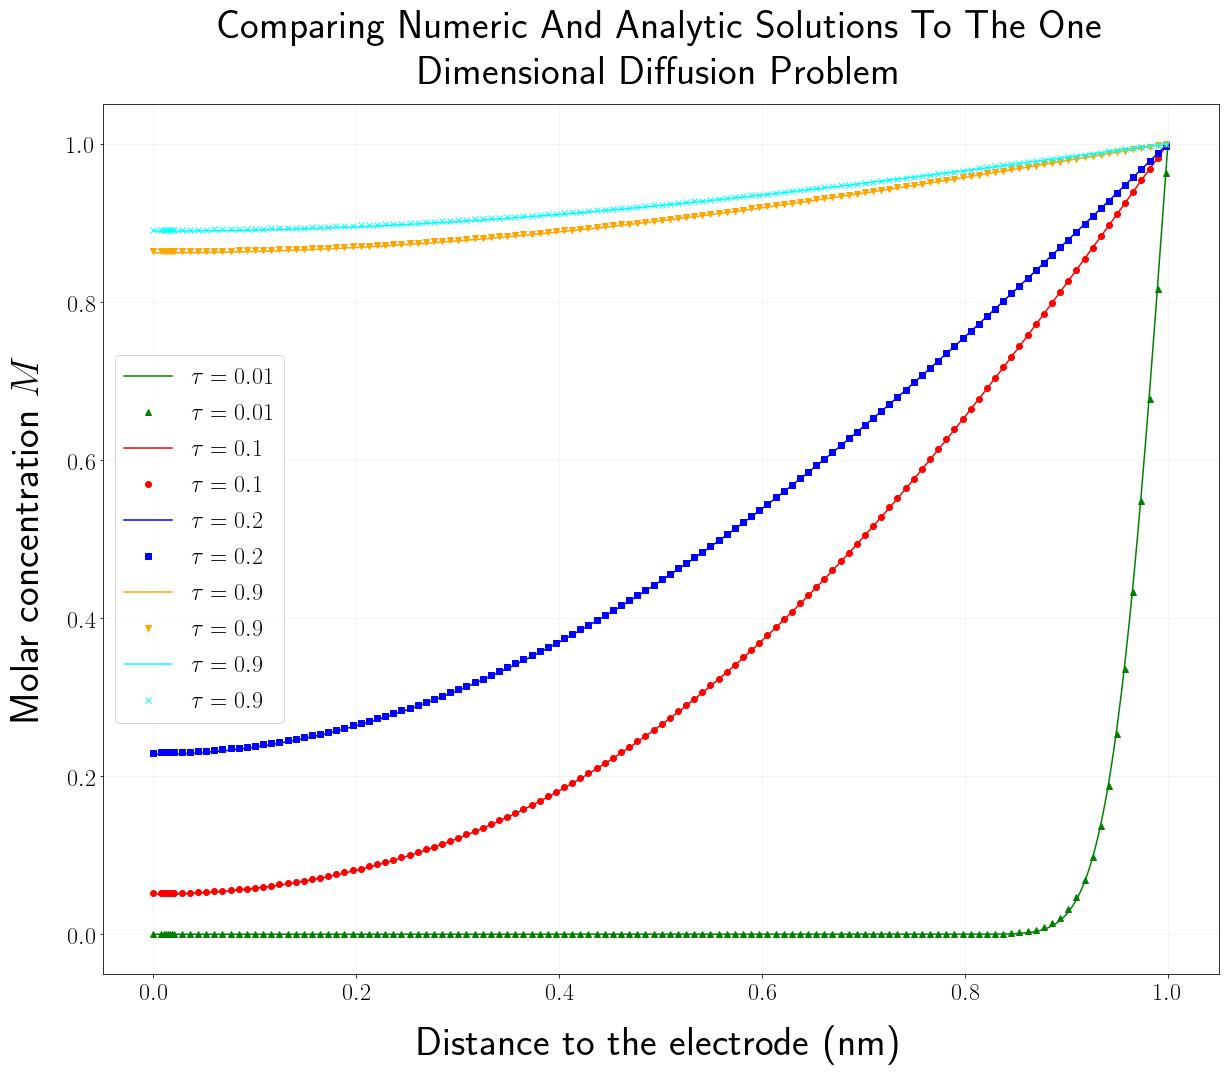

In [7]:
#Cm is the imported analytical solution

mw = 4
fs = 24
fig = plt.figure(figsize=(20,16))
n = 10
plt.title('Comparing Numeric And Analytic Solutions To The One \n Dimensional Diffusion Problem',fontweight='bold')
plt.plot(xi, to_molar * Cm(xi, 0.001, params), 'g-', label=r'$\tau=0.01$')
plt.plot(remove_points(xi, n), remove_points(C(0.001), n), 'g^', label=r'$\tau=0.01$')
plt.plot(xi, to_molar * Cm(xi, 0.1, params), 'r-', label=r'$\tau = 0.1$')
plt.plot(remove_points(xi, n), remove_points(C(0.1), n), 'ro', label=r'$\tau = 0.1$')
plt.plot(xi, to_molar * Cm(xi, 0.2, params), 'b-', label = r'$\tau=0.2$')
plt.plot(remove_points(xi, n), remove_points(C(0.2), n), 'bs', label = r'$\tau=0.2$')
plt.plot(xi, to_molar * Cm(xi, 0.9, params), '-', color="orange", label = r'$\tau=0.9$')
plt.plot(remove_points(xi, n), remove_points(C(0.9), n), 'v', color="orange", label = r'$\tau=0.9$')
plt.plot(xi, to_molar * Cm(xi, 0.99, params), '-', color="aqua", label = r'$\tau=0.9$')
plt.plot(remove_points(xi, n), remove_points(C(0.99), n), 'x', color="aqua", label = r'$\tau=0.9$')
plt.ylabel(r'Molar concentration $M$')
plt.xlabel(r'Distance to the electrode (nm)')
plt.legend(prop={'size': fs})
plt.xticks(size = fs)
plt.yticks(size = fs)
plt.savefig('../../../img/concentration-diffusiononly-comparison.eps', format='eps', dpi=1000, fontsize=16, fontweight='bold')
plt.show()


$\Delta$ marks are the numeric values and continuous lines are the analytical values.